In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

from pitch_geo.constants import DATA_FOLDER
from pitch_geo import data
from pitch_geo.models import models
import pitch_geo.vis_utils as vis_utils

In [2]:
df = data.get_keypoints(dataset='train')

In [3]:
IMG_SIZE = 240
BATCH_SIZE = 32
EPOCHS = 100
NUM_KEYPOINTS = 34  # 34 pairs each having x and y coordinates

keypoint_ids = sorted(df['kid'].unique())
LABELS = {key: value for key, value in zip(range(len(keypoint_ids)), keypoint_ids)}

In [17]:
DIRECTORY = DATA_FOLDER / 'images/test'

In [37]:
AUTOTUNE = tf.data.AUTOTUNE

# Get the model

In [4]:
!ls checkpoints/20221123_234541/

checkpoint
weights.001-0.100638.data-00000-of-00001
weights.001-0.100638.index
weights.002-0.054403.data-00000-of-00001
weights.002-0.054403.index
weights.003-0.024111.data-00000-of-00001
weights.003-0.024111.index
weights.004-0.014155.data-00000-of-00001
weights.004-0.014155.index
weights.005-0.011311.data-00000-of-00001
weights.005-0.011311.index
weights.006-0.008802.data-00000-of-00001
weights.006-0.008802.index
weights.007-0.008488.data-00000-of-00001
weights.007-0.008488.index
weights.008-0.007209.data-00000-of-00001
weights.008-0.007209.index
weights.009-0.005376.data-00000-of-00001
weights.009-0.005376.index
weights.010-0.004198.data-00000-of-00001
weights.010-0.004198.index
weights.011-0.003400.data-00000-of-00001
weights.011-0.003400.index
weights.012-0.003054.data-00000-of-00001
weights.012-0.003054.index
weights.013-0.003189.data-00000-of-00001
weights.013-0.003189.index
weights.014-0.003154.data-00000-of-00001
weights.014-0.003154.index
weights.015-0.002931.data-00000-of-00

In [11]:
model = models.get_model(IMG_SIZE, NUM_KEYPOINTS, dropout=None)
model.load_weights('checkpoints/20221123_234541/weights.049-0.000203')

In [21]:
model_input_shape = model.input_shape[1:3]

## Prepare image loader

In [35]:
from functools import partial

In [32]:
images_paths = sorted(str(x) for x in DIRECTORY.glob('*.jpg'))

In [44]:
dataset_img_paths = tf.data.Dataset.from_tensor_slices(images_paths)

# if isinstance(image_size, int):
#     image_size = (image_size, image_size)

dataset = dataset_img_paths.map(
    partial(
        data.load_image,
        image_size=(IMG_SIZE, IMG_SIZE),
        num_channels=3,
        interpolation='bilinear'
    ),
    num_parallel_calls=AUTOTUNE
)

In [48]:
dataset = (
    dataset
    .batch(BATCH_SIZE)
    .prefetch(buffer_size=AUTOTUNE)
)

In [64]:
keypoints = model.predict(dataset)

10/10 [==============================] - 1s 94ms/step


In [65]:
keypoints = keypoints.reshape(290, NUM_KEYPOINTS, 3).reshape(-1, 3)

In [154]:
kid = pd.Series([label for _, label in LABELS.items()])
kid = pd.concat([kid for _ in range(290)], ignore_index=True)

def strip_datafolder_name(path: str):
    if str(DATA_FOLDER) in path:
        return path[len(str(DATA_FOLDER)) + 1:]
    return path

paths = pd.concat(
    [
        pd.Series([strip_datafolder_name(p) for _ in range(NUM_KEYPOINTS)])
        for p in images_paths
    ],
    ignore_index=True
)

df = pd.DataFrame(data={
    'x': keypoints[:, 0],
    'y': keypoints[:, 1],
    'vis': keypoints[:, 2],
    'dataset': 'test',
    'kid': kid,
    'image_path': paths
})

In [143]:
def scale_xy(df):
    df['x'] = round(df['x'] * 1920).astype('int64')
    df['y'] = round(df['y'] * 1080).astype('int64')
    return df


def visibility(df, threshold=0.5):
    df['vis'] = df['vis'].apply(lambda x: 2 if x >= threshold else 0)
    return df

In [155]:
df = scale_xy(df)
df = visibility(df)

In [156]:
df

,x,y,vis,dataset,kid,image_path
0,0,0,0,test,1,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
1,119,228,2,test,2,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
2,0,0,0,test,3,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
3,5,7,0,test,4,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
4,0,0,0,test,5,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
...,...,...,...,...,...,...
9855,4,1,0,test,32,images/test/fe0ae584ba268e6292f553d7494f27.jpg
9856,0,2,0,test,33,images/test/fe0ae584ba268e6292f553d7494f27.jpg
9857,2,2,0,test,34,images/test/fe0ae584ba268e6292f553d7494f27.jpg
9858,1,1,0,test,35,images/test/fe0ae584ba268e6292f553d7494f27.jpg


In [150]:
df['kid'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 25, 26, 27, 28, 29, 31, 32, 33, 34, 35, 39])

In [153]:
df_test

,x,y,vis,kid,dataset,image_path
149058,0,0,0,1,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149059,0,0,0,2,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149060,0,0,0,3,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149061,0,0,0,4,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149062,0,0,0,5,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
...,...,...,...,...,...,...
160363,0,0,0,35,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160364,0,0,0,36,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160365,0,0,0,37,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160366,0,0,0,38,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg


In [135]:
df_test = data.get_keypoints(dataset='test')

In [152]:
set(df_test['kid'].unique()) - set(df['kid'].unique())

{24, 30, 36, 37, 38}

In [175]:
def get_remaining_keypoints(img_path):
    df_tmp = pd.DataFrame({
        'x': 0,
        'y': 0,
        'vis': 0,
        'kid': [24, 30, 36, 37, 38],
        'dataset': 'test',
        'image_path': img_path
    })
    return df_tmp

In [176]:
remaining_keypoints = pd.concat((get_remaining_keypoints(img_path) for img_path in df['image_path'].unique()), ignore_index=True)

In [177]:
df = pd.concat([df, remaining_keypoints], ignore_index=True)

In [182]:
df = df.sort_values(by=['image_path', 'kid'])

# Plot the predictions to see if they are ok

In [2]:
df = pd.read_csv('test_keypoints_teacher_forcing.csv', header=0)

In [3]:
df

,x,y,vis,dataset,kid,image_path
0,0,0,0,test,1,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
1,258,274,2,test,2,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
2,0,0,0,test,3,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
3,0,0,0,test,4,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
4,0,0,0,test,5,images/test/0117b5a019bafe1bff3b93516fc1be.jpg
...,...,...,...,...,...,...
11305,0,0,0,test,35,images/test/fe0ae584ba268e6292f553d7494f27.jpg
11306,0,0,0,test,36,images/test/fe0ae584ba268e6292f553d7494f27.jpg
11307,0,0,0,test,37,images/test/fe0ae584ba268e6292f553d7494f27.jpg
11308,0,0,0,test,38,images/test/fe0ae584ba268e6292f553d7494f27.jpg


In [4]:
output_dir = Path('outputs/test4')
output_dir.mkdir(exist_ok=True, parents=True)

In [33]:
%matplotlib

for img_path in df_all[df_all['dataset'] == 'test']['image_path'].unique():
    vis_utils.visualize_keypoints(image_path=img_path, df=df_all)
    plt.savefig(fname=(output_dir / Path(img_path).name))
    plt.close()

Using matplotlib backend: agg


In [203]:
model.save('best_model')

INFO:tensorflow:Assets written to: best_model/assets


INFO:tensorflow:Assets written to: best_model/assets


In [28]:
df_all = pd.read_csv('data/df_keypoints.csv', header=0)

In [21]:
for i in range(len(df_all)):
    kid = df_all.iloc[i]['kid']
    image_path = df_all.iloc[i]['image_path']
    tmp = df.query(f'kid=="{kid}" and image_path == "{image_path}"')
    if len(tmp):
        print(tmp)
        break

       x  y  vis dataset  kid                                      image_path
11037  2  1    0    test    1  images/test/f585ed04d5e3b076ad206dd6085297.jpg


In [29]:
for _, row in df.iterrows():
    kid = row['kid']
    image_path = row['image_path']
    
    idx = df_all.query(f'kid=="{kid}" and image_path == "{image_path}"').index
    df_all.loc[idx, 'x'] = row['x']
    df_all.loc[idx, 'y'] = row['y']
    df_all.loc[idx, 'vis'] = row['vis']

In [32]:
df_all[df_all['dataset'] == 'test']

,x,y,vis,kid,dataset,image_path
149058,2,1,0,1,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149059,11,15,0,2,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149060,0,0,0,3,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149061,30,26,0,4,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
149062,0,0,0,5,test,images/test/f585ed04d5e3b076ad206dd6085297.jpg
...,...,...,...,...,...,...
160363,0,0,0,35,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160364,0,0,0,36,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160365,0,0,0,37,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg
160366,0,0,0,38,test,images/test/1a086eda9797612fa9c24b38cd94fc.jpg


In [34]:
df_all.to_csv('df_keypoints.csv', index=False)

# Put keypoints on images

In [2]:
%load_ext autoreload
%autoreload 2

from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd

from pitch_geo import vis_utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
output_dir = Path('outputs/test_21_12_2022')
output_dir.mkdir(exist_ok=True, parents=True)

In [5]:
keypoints_df = pd.read_csv('outputs/test_21_12_2022.csv')

In [6]:
for img_path in keypoints_df['image_path'].unique():
    vis_utils.visualize_keypoints(image_path=img_path, df=keypoints_df)
    plt.savefig(fname=(output_dir / Path(img_path).name))
    plt.close()

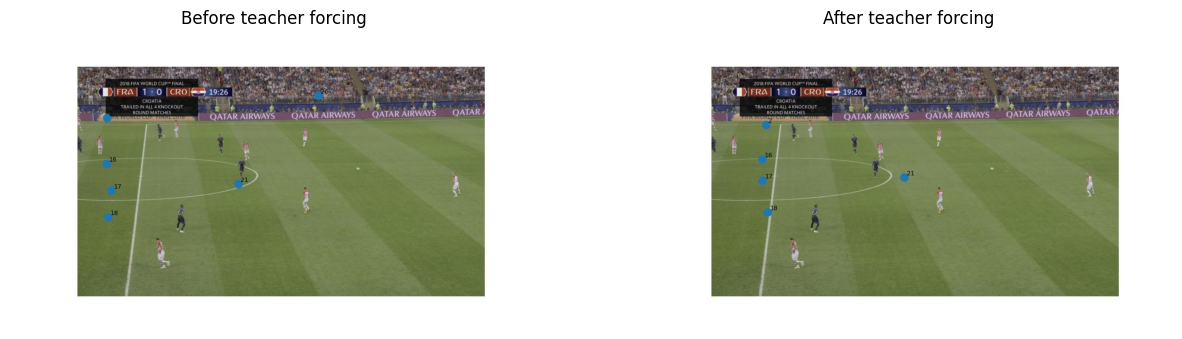

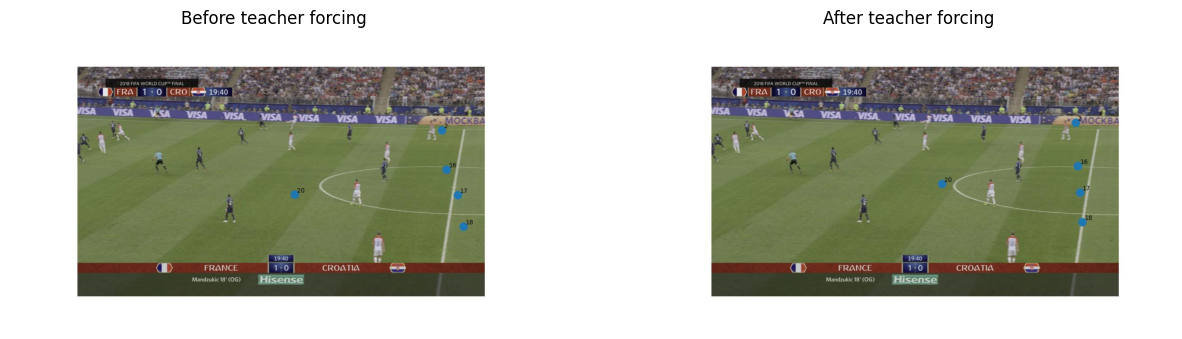

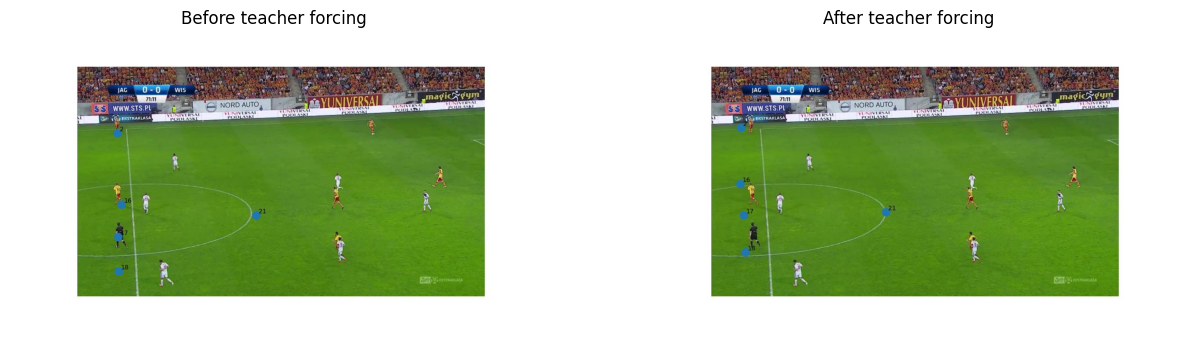

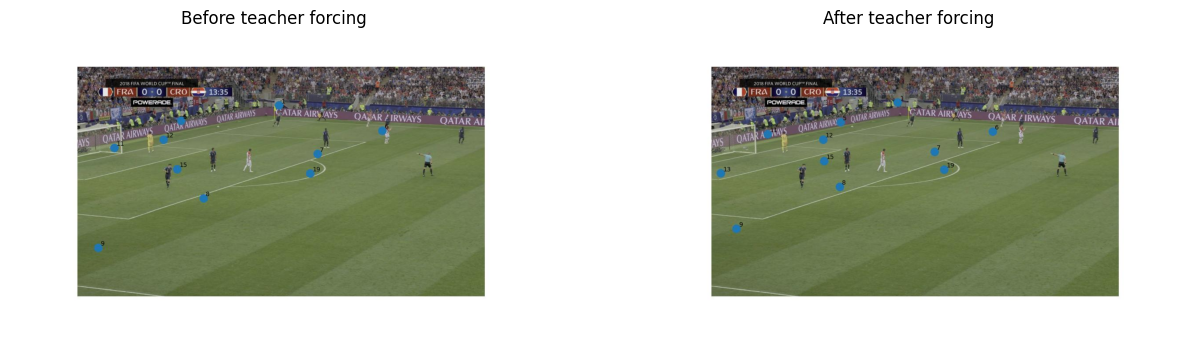

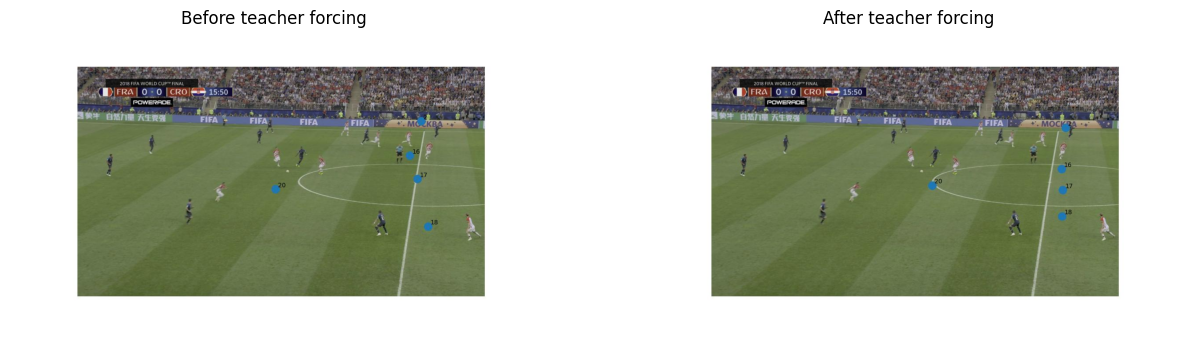

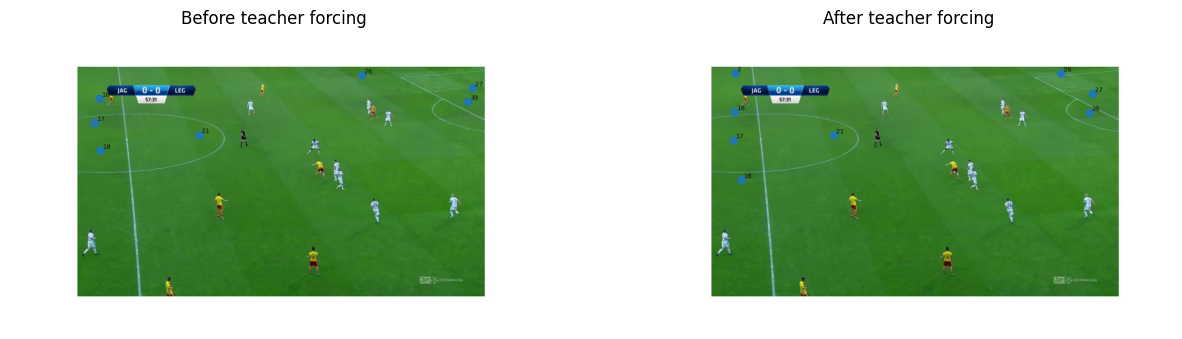

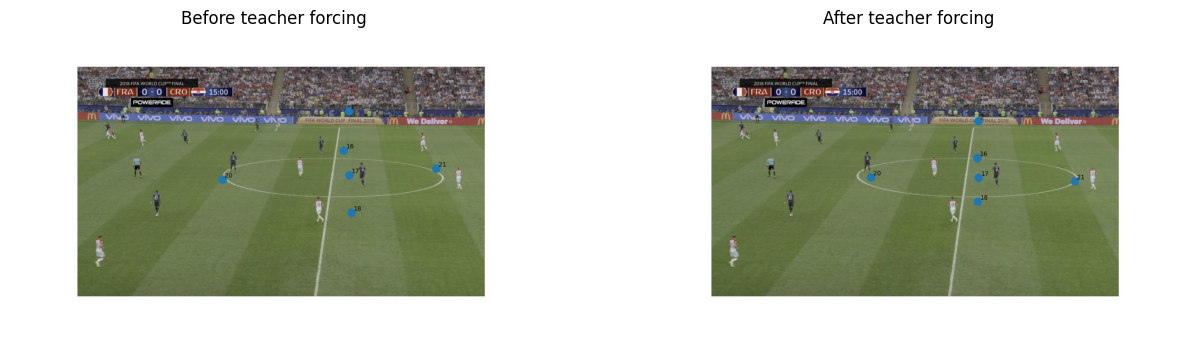

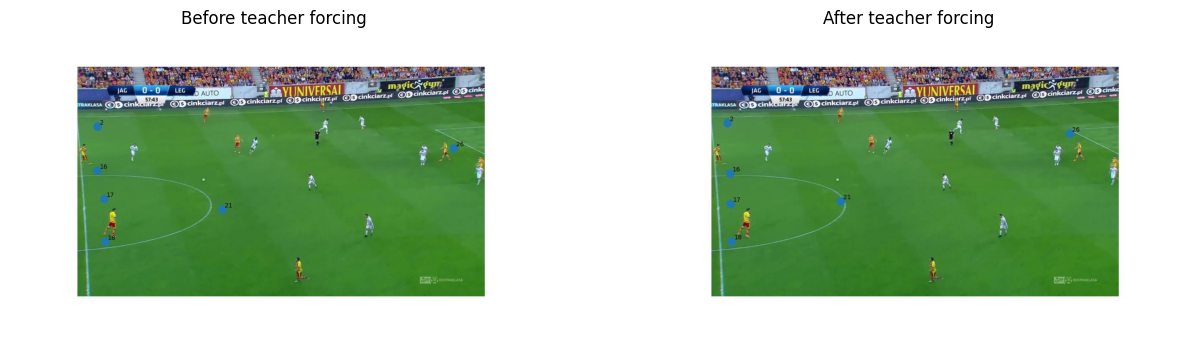

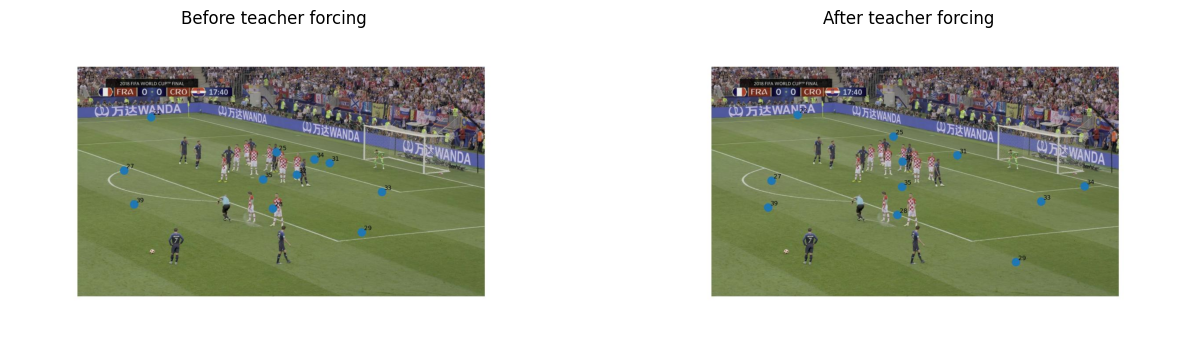

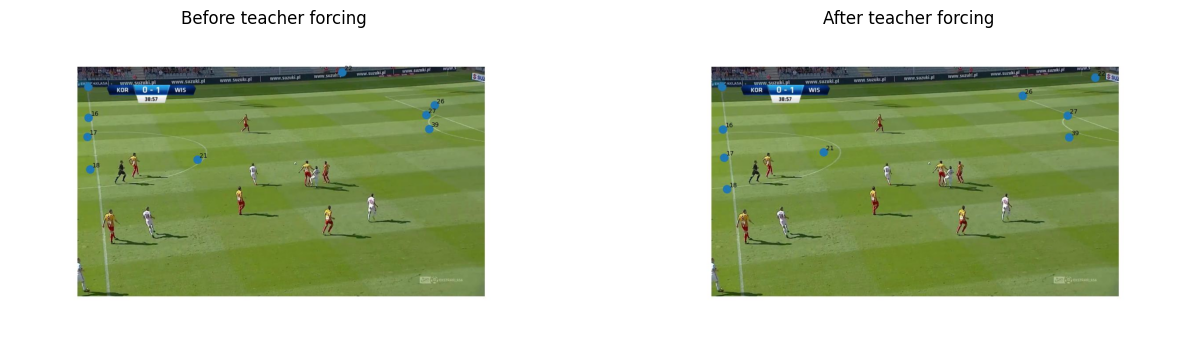

In [8]:
# %matplotlib inline

output_dir_old = Path('outputs/test2')

for img_path in keypoints_df['image_path'].unique()[:10]:
    fig, ax = plt.subplots(1, 2, figsize=(15, 15))
    img_old = plt.imread(output_dir_old / img_path.split('/')[-1])
    img_new = plt.imread(output_dir / img_path.split('/')[-1])
    
    ax[0].imshow(img_old)
    ax[0].set_title('Before teacher forcing')
    ax[0].axis('off')
    
    ax[1].imshow(img_new)
    ax[1].set_title('After teacher forcing')
    ax[1].axis('off')
    
    plt.show()

So if $\mathbf{w} = (x, y, v)$ is a ground trouth keypoint and $\mathbf{\hat{w}} = (\hat{x}, \hat{y}, \hat{v})$ is a model's prediction I define the loss to be:

\begin{equation}
L ( \mathbf{w}, \mathbf{\hat{w}} ) = \lambda \cdot Position(x, y, \hat{x}, \hat{y}, v) + (1 - \lambda) \cdot Crossentropy(v, \hat{v}),
\end{equation}

where

$Position$ is a L2 loss of visible coordinates, given by the function

\begin{equation}
    Position(x, y, \hat{x}, \hat{y}, v) =
    \left\{
        \begin{array}{ll}
            ||(x, y) - (\hat{x}, \hat{y}) ||^2  & \mbox{if } v \neq 0 \\
            0 & \mbox{if } v = 0
        \end{array}
    \right.
\end{equation}

$Crossentropy$ is a binary crossentropy function and $\lambda$ is a parameter weighting the importance of the two losses. 
I found $\lambda = 0.95$ to give good results.


# Modify df_keypoints.csv infered test values

In [22]:
df_all = pd.read_csv('data/df_keypoints.csv', header=0)
df_test = pd.read_csv('outputs/test_21_12_2022.csv')

In [23]:
df_all_org = df_all.copy()

In [24]:
for _, row in df_test.iterrows():
    kid = row['kid']
    image_path = row['image_path']
    
    idx = df_all.query(f'kid=="{kid}" and image_path == "{image_path}"').index
    df_all.loc[idx, 'x'] = row['x']
    df_all.loc[idx, 'y'] = row['y']
    df_all.loc[idx, 'vis'] = row['vis']

In [29]:
df_all.to_csv('df_keypoints_21_12_2022.csv', index=False)